<a href="https://colab.research.google.com/github/succSeeded/dl-2025/blob/main/hws/week04_finetuning/seminar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch
import torch
import torchvision
from torchvision import transforms
# I, sadly, have only one GPU, so I had to append :0 to cuda to avoid errors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# Ensure that output below says `device=device(type='cuda')` - you will need CUDA for faster model runs
# If in Colab, we recommend that you go to Runtime -> Change Runtime Type -> GPU

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='2.7.1+cu126', torchvision.__version__='0.22.1+cu126', device=device(type='cuda', index=0), torch.get_num_threads()=8


In [2]:
# loading Imagenet class labels for interpreting classification results
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


In [3]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);        # set the model to evaluation mode

In [4]:
# Create model clone with altered last layer
embedding_model = deepcopy(model)  # start with a clone of the original model
embedding_model.fc = torch.nn.Identity() # instead of classifier head - do nothing
embedding_model = embedding_model.to(device)  # move to CUDA if available

In [5]:
# download the dataset
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O data.zip -q --show-progress
!unzip -qn data.zip -d data/
!rm data.zip
!ls data/dogs_vs_cats_1000 | wc -l  # should be 2000 images extracted

data.zip            100%[===================>]  44.25M  10.7MB/s    in 4.1s    
2000


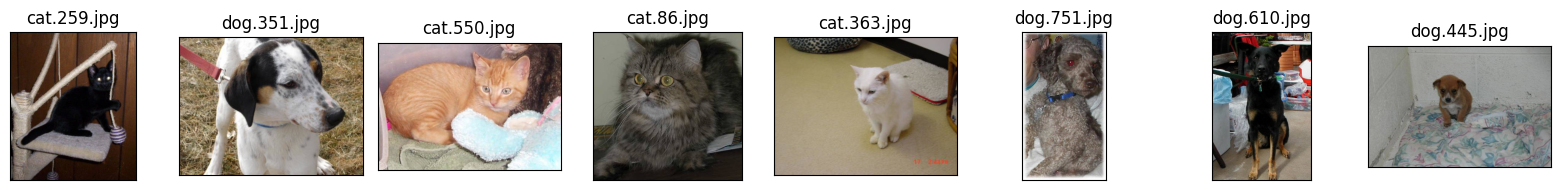

In [6]:
# Sample pets images
import random
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

dataset_path = os.path.join("data", "dogs_vs_cats_1000")

fnames = [fn for fn in os.listdir(dataset_path)]
for ax, fname in zip(axs.ravel(), random.choices(fnames, k=8)):
    img_ = Image.open(os.path.join(dataset_path, fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [7]:
# Here we generate image embeddings using the activations before the last layer
# use batches to accelerate the process

X_ = []  # storage for batches embeddings
Y_ = []  # storage for batches labels

filenames = [fname for fname in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, fname))]
batch_size = 64
x_batch_list = []  # to accumulate batch components

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        img = Image.open(os.path.join(dataset_path, fname))
        img_torch = transforms.ToTensor()(img.resize((224, 224)))
        x_batch_list.append(img_torch)
        Y_.append(1 if fname.startswith("cat") else 0)

        if len(x_batch_list) == batch_size or i >= len(filenames) - 1:
            x_batch = torch.stack(x_batch_list) # [64, 3, H, W]
            # use your embedding model to produce embeddings vectors, save results on CPU
            embeddings = embedding_model(x_batch.to(device)).cpu()

            assert isinstance(embeddings,  torch.Tensor) and embeddings.device.type == "cpu"
            assert embeddings.ndim == 2 and embeddings.shape[1] == 512
            X_.append(embeddings)
            x_batch_list = []

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array.
Y = np.array(Y_[:len(X)])  # convert labels into np array; crop if we ended prematurely

print(X.shape, Y.shape, np.mean(Y))

assert X.ndim == 2 and X.shape[1] == 512
assert X.shape[0] == len(filenames)
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.49 <= np.mean(Y) <= 0.51

(2000, 512) (2000,) 0.5


### Using model embeddings as classifier features

Train sklearn model, evaluate validation accuracy (should be >90%)

In [9]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

__Task 1 (2 points): train the model and evaluate its accuracy on a hold-out set.__
- write the code for cats/dogs classification using the embeddings created above. Use any classification tools that you learned. Reach at least 95% accuracy. __(1 point)__.  Try few different tools if accuracy is not high enough. <br>
(You may choose any classifier algorithm as long as it gets above 95% accuracy. To get the max grade here, you need to tune main hyperparameters of your chosen algorithm (e.g. k for KNN, tree depth, logreg C) depending on how many data points you have. )
- try this excercise with much smaller training set. Find the lowest train set size at which you can still predict cat/dog class with 95% accuracy __(1 point)__ <br>
(note: exact threshold may depend on algorightm choice and train/test split. Show your effort in  experimenting with low train set sizes.)

In [10]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# np.random.seed(120)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# let us create a "random" subsample for testing purposes
subset_size = 200
subset_ids = np.random.choice(
    np.arange(X_train.shape[0]), size=subset_size, replace=False
)

X_trainSub = X_train[subset_ids]
Y_trainSub = Y_train[subset_ids]

# # AdaBoost achieves >95% accuracy with at least 170 data entries
# pipe = Pipeline(
#     [
#         ("transform", StandardScaler()),
#         ("model", AdaBoostClassifier(n_estimators=100)),
#     ]
# ).fit(X_trainSub, Y_trainSub)

# # LogReg **can** achieve >95% accuracy score with 72 data entries, but this is unreliable since it is the case only for certain
# # random seeds. It can reliably get to 95% with 150 entries
# pipe = Pipeline(
#     [
#         ("transform", StandardScaler()),
#         (
#             "model",
#             LogisticRegression(dual=True, intercept_scaling=2.0, solver="liblinear"),
#         ),
#     ]
# ).fit(X_trainSub, Y_trainSub)

# KNN has to have at least 200 entries to somewhat reliably breach 95% accuracy threshold 
pipe = Pipeline(
    [
        ("transform", StandardScaler()),
        (
            "model",
            KNeighborsClassifier(n_neighbors=7, weights="distance"),
        ),
    ]
).fit(X_trainSub, Y_trainSub)

Y_pred = pipe.predict(X_test)
acc_score = (Y_pred == Y_test).sum() / Y_pred.shape[0]

print(f"accuracy = {acc_score:.1%}")
print(f"Is it more than or equal to 95%? {acc_score >= 0.95}")

accuracy = 93.5%
Is it more than or equal to 95%? False
CPU times: user 770 ms, sys: 3.78 ms, total: 774 ms
Wall time: 61.7 ms


## Torchvision Datasets
- Built-in datasets https://pytorch.org/vision/stable/datasets.html#built-in-datasets

- Datasets and Dataloaders at `torch.utils.data`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Torchvision classes for custom datasets  https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets

# Problem 2: Clasification of cat/dog breeds using Oxford pets dataset

The next problem is to classify specific cat / dog breeds from popular Oxford pets dataset. It is conveniently provided by Pytorch so loading and using it is very easy.

Dataset home page: https://www.robots.ox.ac.uk/~vgg/data/pets/

Available from Pytorch: https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet



In [11]:
# Loading train and test subsets of the dataset

train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=True,
    transform=train_transform,
)
test_dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    split="test",
    target_types="category",
    download=True,
    transform=test_transform,
)

print("dataset sizes:", len(train_dataset), len(test_dataset))

print(train_dataset.classes)

dataset sizes: 3680 3669
['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


### Finetuning CNN: classification layer only:

__Task 2: (3 points)__:<br>
Complete the code below and reach at least 85% accuracy by training only the classification layer:

In [12]:
import torch.nn as nn

ft_model = deepcopy(model).to(device)
ft_model.fc = nn.Linear(512, 37)
ft_model = ft_model.to(device)

# your task:
# 1) freeze all model parameters
# 2) replace model.fc with a new linear layer that has the appropriate number of outputs

params_to_train = []

for name, param in ft_model.named_parameters():
    if name.startswith("fc."):
        params_to_train.append(param)
        param.requires_grad = True
        print(name, param.shape)
    else:
        param.requires_grad = False

optimizer = torch.optim.Adam(params_to_train)
criterion = torch.nn.CrossEntropyLoss()

assert all(not p.requires_grad for p in ft_model.parameters() if p not in set(ft_model.fc.parameters()))
assert ft_model.fc.out_features == len(train_dataset.classes)
assert ft_model.fc.weight.device == device, f"ft_model.fc must be on {device}"
assert ft_model.fc.weight.requires_grad

fc.weight torch.Size([37, 512])
fc.bias torch.Size([37])


In [2]:
import pathlib

def train(model, opt, loss_func, train_dataset, test_dataset, num_epochs:int = 10, batch_size:int = 64, stop:int = 7, device:str = None, silent:bool = False) -> dict:
    """
    A function for training torch models that I kindly took from the professor (sorry) but now with torch dataloaders

    Args:
        model: torch model to train
        opt: optimizer for that model
        loss_func: torch loss function
        train_dataset: torch.Dataset used for training
        test_dataset: torch.Dataset used for validation
        num_epochs: total amount of full passes over training data (default: 100)
        batch_size: number of samples processed in one iteration (default: 64)
        stop: number of iterations that loss can decrease for before the training proces stops (default: 7)
        device: torch tensors location (default: None)
        silent: silence the training logs (default: False)
    """
    best_val_acc = 0.0
    best_epoch = 0
    history = defaultdict(list)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        
        train_losses = []
        pbar = tqdm(train_dataloader, leave=False)
        for x_batch, y_batch in pbar:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
    
            # calculate model predictions, calculate loss, make optimizer step
            logits = model(x_batch)
            loss = loss_func(logits, y_batch).mean()
    
            train_losses.append(loss.item())
            pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # And a full pass over the validation data:
        model.train(False)     # disable dropout / use averages for batch_norm
        model.eval()
        val_losses = []
        val_cnt, val_correct = 0, 0
        pbar = tqdm(test_dataloader, leave=False)
        with torch.no_grad():  # do not store intermediate activations
            for x_batch, y_batch in pbar:
    
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                # get model predictions, measure loss, collect data for accuracy calc
                logits = model(x_batch)
                
                y_pred = logits.argmax(-1)
                loss = loss_func(logits, y_batch).mean()
        
                val_losses.append(loss.item())
                val_cnt += y_batch.shape[0]
                val_correct += (y_batch == y_pred).sum().item()
                pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        accuracy = val_correct / val_cnt
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)
        if not silent:
            print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

        if best_val_acc < accuracy:
            best_val_acc = accuracy
            best_epoch = epoch
            pathlib.Path("./models/").mkdir(exist_ok=True)
            torch.save(model.state_dict(), f"models/model_new_head.pt2")


        if epoch - best_epoch >= stop:
            if not silent:
                print(f"Model did not see any loss improvements for {stop} epochs, aborting...")
            model.load_state_dict(torch.load(f"models/model_new_head.pt2", weights_only=True))
            model.eval()
            break
    return history

In [18]:
def evaluate(model, test_dataset, batch_size:int=64) -> float:
    """
    A function that calculates macro accuracy of a `model` on `test_dataset`
    """
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    Y_probs, Y_true = [], []
    for x_batch, y_batch in tqdm(test_dataloader):
        with torch.no_grad():
            prediction = model(x_batch.to(device))
            probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
            Y_true.append(y_batch)
            Y_probs.append(probs)
    
    Y_probs = torch.cat(Y_probs, axis=0)
    Y_true = torch.cat(Y_true)
    Y_pred = Y_probs.argmax(-1)
    
    correct = (Y_pred.numpy() == Y_true.numpy()).sum()
    total = Y_true.shape[0]
    return correct / total

In [16]:
# train the finetuning model in a standard training loop.

hist = train(ft_model, optimizer, criterion, train_dataset, test_dataset, device=device, num_epochs=15, stop=2, silent=True)
accuracy = max(hist['accuracy'])
accuracy

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [17]:
# This part of finetuning alone should deliver at least 85% accuracy.
assert accuracy > 0.85

In [18]:
acc = evaluate(ft_model, test_dataset)
print(f"Overall accuracy = {acc*100.0:0.2f}%")

  0%|          | 0/58 [00:00<?, ?it/s]

Overall accuracy = 87.41%


In [19]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    y_predicted = Y_probs[class_preds].numpy().argmax(-1)
    acc1 = (y_predicted == i).mean()
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1

df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

  0%|          | 0/58 [00:00<?, ?it/s]

,acc1
Keeshond,100.00%
Leonberger,100.00%
German Shorthaired,99.00%
Samoyed,99.00%
Saint Bernard,98.00%
Great Pyrenees,98.00%
Yorkshire Terrier,95.00%
Havanese,95.00%
Japanese Chin,95.00%
Scottish Terrier,94.95%


### Finetuning CNN: now unfreeze and train all layers:

__task 3 (5 points)__: Based on the previous task, continue finetuning the model run by training all of its layers. Obtain at least 90% accuracy (macro average, as defined in the code).
To reach 90%, you will need to experiment with network and/or training code, start from using improvements from the list below:

Scoring:
- reaching 90% accuracy - __3 points__
- testing out all 4 of these improvements - __2 points__:
    - Hyperparameters optimization
    - Image augmentation
    - Pretrained model selection
    - Early stopping training at epoch with best metric and / or loading the weights of best epoch. [read about `state_dict`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)
    
(you may not necessarily get spectacular results right away. Experiment and describe your actions and findings in a brief report in this notebook.)
- scoring above 90% -- __+1 BONUS point__ for every 1% improvement in accuracy above 90%

__Guidelines__: to improve quality of the finetuned model we can now train all of its layers.
- do this after initial training of classification layer
- set learning rate to much lower level to avoid explosion
- make all layers trainable using `requires_grad` param

In [20]:
# Continue training with all layers involved

for name, param in ft_model.named_parameters():
    params_to_train.append(param)
    param.requires_grad = True

assert all (p.requires_grad for p in ft_model.parameters())

optimizer = torch.optim.Adam(ft_model.named_parameters(), lr=0.00003)  # reduce LR to avoid explosion

In [21]:
# train the finetuning model in a standard training loop.

hist_new = train(ft_model, optimizer, criterion, train_dataset, test_dataset, num_epochs=30, device=device)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=0.19990  val_loss=0.36893  accuracy=89.15%  epoch_time=19.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.07743  val_loss=0.35198  accuracy=89.04%  epoch_time=19.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.04476  val_loss=0.34843  accuracy=89.56%  epoch_time=18.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.02944  val_loss=0.34449  accuracy=89.34%  epoch_time=18.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.02106  val_loss=0.34257  accuracy=89.32%  epoch_time=19.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.01613  val_loss=0.33985  accuracy=89.45%  epoch_time=19.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=0.01274  val_loss=0.33650  accuracy=89.83%  epoch_time=19.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=0.01073  val_loss=0.33753  accuracy=89.62%  epoch_time=19.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=0.00940  val_loss=0.34017  accuracy=89.72%  epoch_time=19.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 9: train_loss=0.00762  val_loss=0.33836  accuracy=89.78%  epoch_time=19.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.10: train_loss=0.00654  val_loss=0.34055  accuracy=89.83%  epoch_time=19.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.11: train_loss=0.00551  val_loss=0.34080  accuracy=89.83%  epoch_time=18.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.12: train_loss=0.00477  val_loss=0.33389  accuracy=90.08%  epoch_time=19.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.13: train_loss=0.00443  val_loss=0.34016  accuracy=89.94%  epoch_time=19.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.14: train_loss=0.00412  val_loss=0.33342  accuracy=90.02%  epoch_time=19.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.15: train_loss=0.00354  val_loss=0.34021  accuracy=89.89%  epoch_time=19.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.16: train_loss=0.00312  val_loss=0.33642  accuracy=90.27%  epoch_time=19.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.17: train_loss=0.00289  val_loss=0.34049  accuracy=90.00%  epoch_time=19.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.18: train_loss=0.00258  val_loss=0.33792  accuracy=90.13%  epoch_time=19.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.19: train_loss=0.00255  val_loss=0.34233  accuracy=90.08%  epoch_time=19.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.20: train_loss=0.00226  val_loss=0.34165  accuracy=89.94%  epoch_time=19.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.21: train_loss=0.00221  val_loss=0.34005  accuracy=90.11%  epoch_time=19.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.22: train_loss=0.00200  val_loss=0.34581  accuracy=90.11%  epoch_time=19.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep.23: train_loss=0.00186  val_loss=0.34073  accuracy=90.08%  epoch_time=19.4s
Model did not see any loss improvements for 7 epochs, aborting...


In [22]:
acc = evaluate(ft_model, test_dataset)
print(f"Overall accuracy = {acc*100.0:0.2f}%")
assert acc >= 0.9

  0%|          | 0/58 [00:00<?, ?it/s]

Overall accuracy = 90.27%


## Some experiments

In [25]:
# Dataset augmentations
train_transform = transforms.Compose(
    [
        transforms.RandomRotation([-30, 30]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [27]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights 

# Initial model, loss and optimizer selection
# uncomment to select
optim_class = torch.optim.Adam
loss_class = torch.nn.CrossEntropyLoss
model = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
# model = resnet34(weights=ResNet34_Weights.DEFAULT).to(device)
# model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT).to(device)


train_dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="category",
    download=True,
    transform=train_transform,
)
test_dataset = torchvision.datasets.OxfordIIITPet(
    root="./data",
    split="test",
    target_types="category",
    download=True,
    transform=test_transform,
)

model.fc = torch.nn.Linear(512, 37) # ResNet option
# model.classifier[2] = torch.nn.Linear(768, 37) # ConvNeXt option
model = model.to(device)

params_to_train = []

# disable fine-tuning the body weights
for name, param in model.named_parameters():
    if name.startswith("fc."): # ResNet option
    # if name.startswith("classifier.2"): # ConvNeXt option
        params_to_train.append(param)
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = loss_class()
optimizer = optim_class(params_to_train)

print('Training the new "head"...')
hist = train(model, optimizer, criterion, train_dataset, test_dataset, device=device, num_epochs=15, stop=2, silent=True)

acc = evaluate(model, test_dataset)
print(f"Macro-averaged accuracy after training just the new 'head': {acc*100.0:0.2f}%")

# re-enable fine-tuning the body weights
for name, param in model.named_parameters():
    param.requires_grad = True

optimizer = optim_class(model.named_parameters(), lr=0.00003)

print('Training the whole network...')
hist_new = train(model, optimizer, criterion, train_dataset, test_dataset, device=device, num_epochs=30, stop=7, silent=True)

acc = evaluate(model, test_dataset)
print(f"Macro-averaged accuracy after training the whole model: {acc*100.0:0.2f}%")

Training the new "head"...


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
# Load in saved state_dict of finetuned ConvNeXt (since I had to stop the training process manually, as it took way too long time to train)

model.load_state_dict(torch.load(f"models/convnext_model_new_head.pt2", weights_only=True))
model.eval()
acc = evaluate(model, test_dataset)
print(f"Macro-averaged accuracy after training the whole model: {acc*100.0:0.2f}%")

  0%|          | 0/58 [00:00<?, ?it/s]

Macro-averaged accuracy after training the whole model: 94.39%


# STUDENT'S REPORT

Please write a short report describing the steps you took to improve quality. It should be at least a short paragraph with 3-5 sentences and, optionally, any relevant numbers/charts, but there's no upper limit.

Here is what I did:

I implemented a training process cosisting of following steps:
* training data is passed batchwise to the model, loss is calculated and backpropagated;
* model is evaluated on the test set and its performance accuracy is recorded;
* the process is stopped after either a specified amount of epochs pass without accuracy metric increases or the process reaches the maximum allowed number of epochs.

Then I tried it with several different pretrained models and dataset augmentation techniques with `ResNet-18` w/o augmentations serven as a baseline. This resulted in a following table:

| Model | Augment | Accuracy |
| :--: | :--- | :--- |
| `ResNet-18` | None | 90.22% |
| `ResNet-34` | None | 92.04% |
| `ConvNeXt-Tiny`* | None | 94.39% |
| `ResNet-18` | Random Rotation between -30$^\circ$ and 30$^\circ$,<br>horizontal flips  | 90.05% |

Here "accuracy" column corresponds to macro-averaged accuracy after the whole training process is done, "None" in augment column refers to the following transformation sequence:
```python
transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
```

# Bonus task __(optional. 2 more points)__:

Notice that accuracy varies across breeds. Build confusion Propose improvements to the model finetuning process to improve minimal accuracy levels for all classes. Show the model runs.
Measure the improvement in terms of minimal accuracy and micro-averaged accuracy.

# EXTRA STUFF:


## Links:    
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
- [Activations Atlas](https://distill.pub/2019/activation-atlas/)
- more models from https://github.com/huggingface/pytorch-image-models
- Papers with code: benchmarks and model references. https://paperswithcode.com/sota/image-classification-on-imagenet